# 第7章 MCMC法の概要と診断情報



## 7.1 メトロポリスアルゴリズム



### 7.1.2 メトロポリスアルゴリズム



リスト7.1: 乱数生成を10回繰り返した例



Text(0, 0.5, '\\lambda_c')

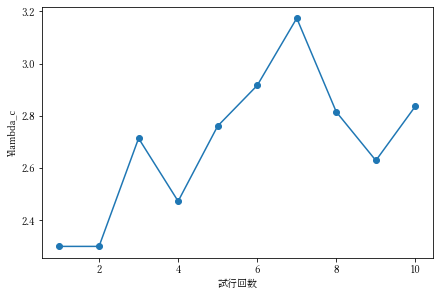

In [1]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] = 'Yu Mincho'

x = np.arange(1, 11)
y = np.array([2.3, 2.3, 2.714, 2.473, 2.761, 2.9165, 3.174, 2.815, 2.629, 2.837])

fig, ax = plt.subplots(constrained_layout=True)

ax.plot(x, y, 'o-')
ax.set_xlabel('試行回数')
ax.set_ylabel(r'\lambda_c')

### 7.1.3 メトロポリス・ヘイスティングスアルゴリズム



リスト7.2: PyMC3で利用できるサンプラーの一覧



In [1]:
import pymc3 as pm
import warnings
warnings.simplefilter('ignore', FutureWarning)

print([x for x in dir(pm.step_methods) if x[0].isupper()])

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


['BinaryGibbsMetropolis', 'BinaryMetropolis', 'CategoricalGibbsMetropolis', 'CauchyProposal', 'CompoundStep', 'DEMetropolis', 'DEMetropolisZ', 'DEMetropolisZMLDA', 'ElemwiseCategorical', 'EllipticalSlice', 'HamiltonianMC', 'LaplaceProposal', 'MLDA', 'Metropolis', 'MetropolisMLDA', 'MultivariateNormalProposal', 'NUTS', 'NormalProposal', 'PGBART', 'PoissonProposal', 'RecursiveDAProposal', 'Slice', 'UniformProposal']


リスト7.3: サンプラーを指定してサンプリングする例



In [3]:
data = [4]

with pm.Model() as model:
    lambda_ = pm.Gamma('lambda', alpha=1.6, beta=1)
    x = pm.Poisson('x', mu=lambda_, observed=data)
    
    step = pm.step_methods.Metropolis()
    
    trace = pm.sample(100, tune=0, step=step,
                      random_seed=1)

Only 100 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [lambda]


Sampling 4 chains for 0 tune and 100 draw iterations (0 + 400 draws total) took 120 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 25% for some parameters.


リスト7.4: 結果のトレースプロット



array([[<AxesSubplot:title={'center':'lambda'}>,
        <AxesSubplot:title={'center':'lambda'}>]], dtype=object)

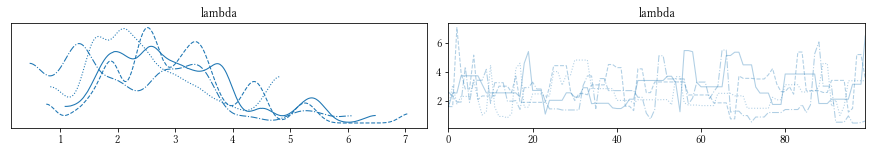

In [4]:
pm.plot_trace(trace)

リスト7.5: 結果のヒストグラム



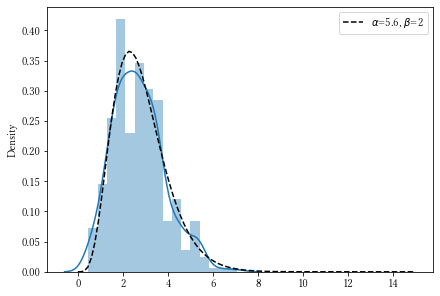

In [5]:
import seaborn as sns
from scipy import stats

alpha = 5.6
beta = 2
lambda_ = np.linspace(0, 15, 100)

fig, ax = plt.subplots(constrained_layout=True)

# 推定結果のヒストグラム
sns.distplot(trace['lambda'], ax=ax)

# 理論的な事後分布
ax.plot(lambda_,
        stats.gamma.pdf(lambda_, alpha, scale=1/beta), 
        'k--',
        label=rf'$\alpha$={alpha}, $\beta$={beta}')

ax.legend()

## 7.2 MCMC法の診断情報



### 7.2.1 結果の保存と読み込み



リスト7.6: PyMC3のインポート



In [6]:
import pymc3 as pm
import warnings
warnings.simplefilter('ignore', FutureWarning)

リスト7.7: サンプリング



In [7]:
data = [5]

with pm.Model() as model:
    lambda_ = pm.Gamma('lambda', alpha=2.6, beta=1)
    x = pm.Poisson('x', mu=lambda_, observed=data)
    
    trace = pm.sample(random_seed=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 136 seconds.


リスト7.8: 結果の要約統計量



In [8]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lambda,3.773,1.38,1.307,6.306,0.034,0.024,1583.0,1937.0,1.0


リスト7.9: データの保存



In [9]:
pm.save_trace(trace, 'my_trace', overwrite=True)

'my_trace'

リスト7.10: データの読み込み



In [10]:
with model:
    trace_l = pm.load_trace('my_trace')

リスト7.11: 読み込んだデータの要約統計量を確認



In [11]:
pm.summary(trace_l)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lambda,3.773,1.38,1.307,6.306,0.034,0.024,1583.0,1937.0,1.0


### 7.2.2 乱数の生成個数の設定



リスト7.12: `draws` 引数と `tune` 引数による乱数の生成個数の設定例



In [12]:
data = [1, 2, 3]

with pm.Model() as model_2:
    mu = pm.Normal('mu', mu=0, sigma=10)
    x = pm.Normal('x', mu=mu, sigma=1, observed=data)
    
    trace_2 = pm.sample(2000, tune=1500, chains=2,
                        random_seed=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [mu]


Sampling 2 chains for 1_500 tune and 2_000 draw iterations (3_000 + 4_000 draws total) took 69 seconds.


リスト7.13: 乱数の生成個数の確認



In [13]:
trace_2['mu'].shape

(4000,)

### 7.2.3 収束の判定



リスト7.14: トレースプロット



array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>]], dtype=object)

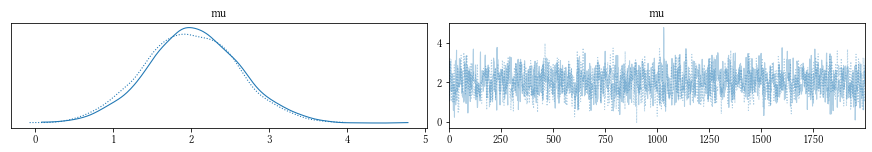

In [14]:
pm.plot_trace(trace_2)

リスト7.15: 要約統計量



In [15]:
pm.summary(trace_2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,2.013,0.592,0.923,3.169,0.015,0.01,1648.0,2397.0,1.0


リスト7.16: `pm.rhat` 関数の使用例



In [16]:
pm.rhat(trace_2)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    mu       float64 1.001

リスト7.17: `pm.plot_forest` 関数で $\hat{R}$ の値を表示



array([<AxesSubplot:title={'center':'94.0% HDI'}>,
       <AxesSubplot:title={'center':'r_hat'}>], dtype=object)

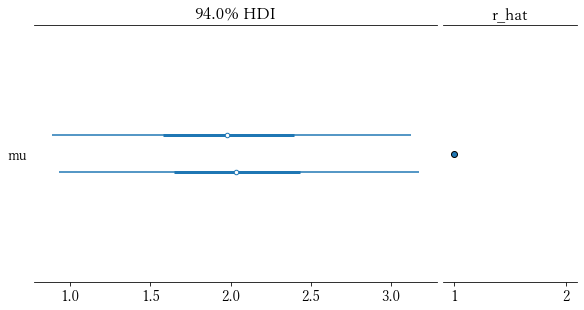

In [17]:
pm.plot_forest(trace_2, r_hat=True)

リスト7.18: サンプルデータの読み込み



In [18]:
import arviz as az

trace_c = az.load_arviz_data('centered_eight')
trace_nc = az.load_arviz_data('non_centered_eight')

リスト7.19: `trace_c` のトレースプロット



array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>]], dtype=object)

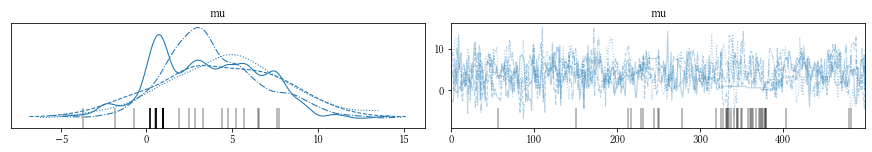

In [19]:
pm.plot_trace(trace_c, var_names='mu')

リスト7.20: `trace_nc` のトレースプロット



array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>]], dtype=object)

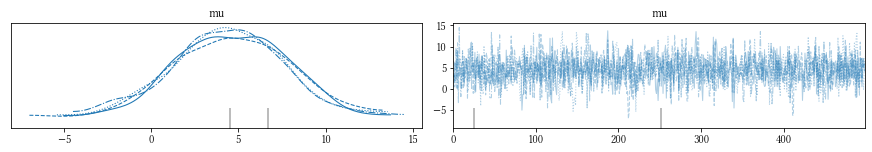

In [20]:
pm.plot_trace(trace_nc, var_names='mu')

リスト7.21: 2つの要約統計量の比較



In [21]:
import pandas as pd

summaries = pd.concat(
    [pm.summary(trace_c, var_names='mu'),
     pm.summary(trace_nc, var_names='mu')]
)
summaries.index = ['centered', 'non_centered']
summaries

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
centered,4.093,3.372,-2.118,10.403,0.215,0.152,250.0,643.0,1.03
non_centered,4.494,3.286,-2.187,10.201,0.068,0.053,2354.0,1401.0,1.00


### 7.2.4 自己相関



リスト7.22: `trace_c` のコレログラム



<AxesSubplot:title={'center':'mu'}>

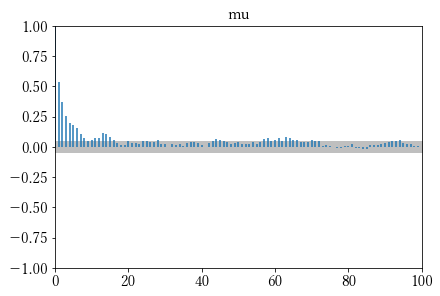

In [22]:
pm.plot_autocorr(trace_c, var_names='mu', combined=True)

リスト7.23: `trace_nc` のコレログラム



<AxesSubplot:title={'center':'mu'}>

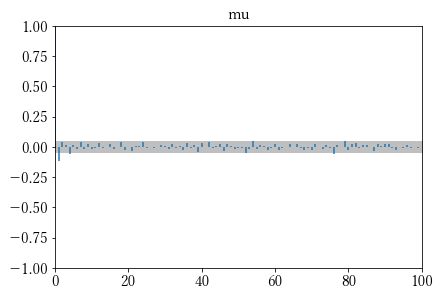

In [23]:
pm.plot_autocorr(trace_nc, var_names='mu', combined=True)

リスト7.24: `pm.ess` 関数の使用例



In [24]:
pm.ess(trace_c, var_names='mu')

<xarray.Dataset>
Dimensions:  ()
Data variables:
    mu       float64 250.3

リスト7.25: `pm.plot_forest` 関数で有効サンプルサイズを表示



array([<AxesSubplot:title={'center':'94.0% HDI'}>,
       <AxesSubplot:title={'center':'ess'}>], dtype=object)

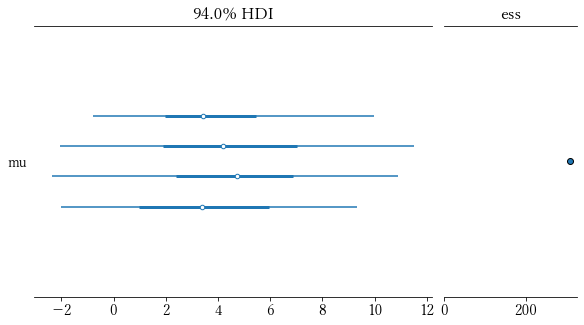

In [25]:
pm.plot_forest(trace_c, var_names='mu', ess=True)

リスト7.26: `pm.mcse` 関数の使用例



In [26]:
pm.mcse(trace_c, var_names='mu')

<xarray.Dataset>
Dimensions:  ()
Data variables:
    mu       float64 0.2148